In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
mean_squared_error, mean_absolute_error, r2_score
)

from fit_adversarial import minority_logit_auc
from fairness_measures import *

df = pd.read_csv("all_vals_race1_interestrate1.csv")

df.drop(
    columns=[
        "Unnamed: 0",
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)

df["minority"] = (
    (df["race_dum_Black"] == 1)
    | (df["race_dum_Native Am, Alaska, Hawaii"] == 1)
    | (df["race_dum_White hisp"] == 1)
    # | (df['race_dum_Asian'] == 1)
)

features = df.drop(
    columns=[
        "Default", "cur_int_rate", "sato", "minority",
        "race_dum_Unknown", "race_dum_Asian", "race_dum_Black",
        "race_dum_Native Am, Alaska, Hawaii", "race_dum_White hisp", "race_dum_White non-hisp"
    ],
    axis=1
)

target = df["cur_int_rate"]

features_numeric = pd.get_dummies(features, drop_first=True)

print(df["minority"].value_counts())


minority
False    15112
True       961
Name: count, dtype: int64


In [14]:
def evaluate_fairness(y_pred, target, minority):
    fairness_metrics = FairnessMetrics(y_pred, target, minority)
    metrics = fairness_metrics.calculate_metrics_with_cross_validation()
    fairness_metrics.train_classifiers(split_data=False)
    print(metrics)
    for criterion in ["independence", "separation", "sufficiency"]:
        fairness_metrics.plot_roc_auc_curve(criterion)
    return metrics

({'independence': 0.007337292446139584, 'separation': 0.0034023671183925595, 'sufficiency': 0.0008904533615831628}, {'independence': 0.0004889254987827947, 'separation': 0.00040563908906293927, 'sufficiency': 0.0002770347621973752})


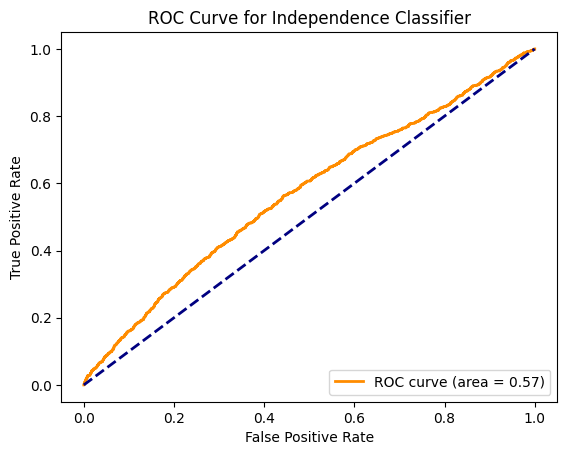

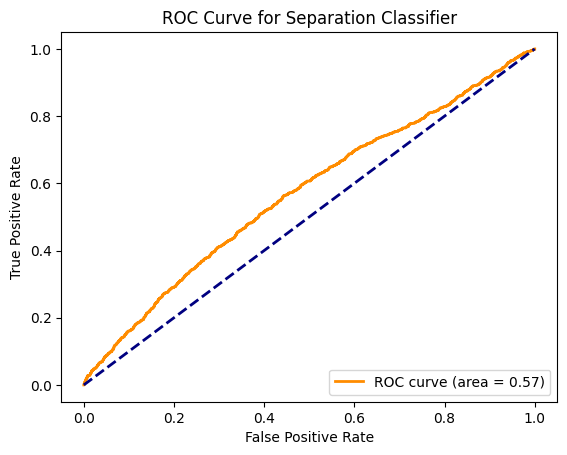

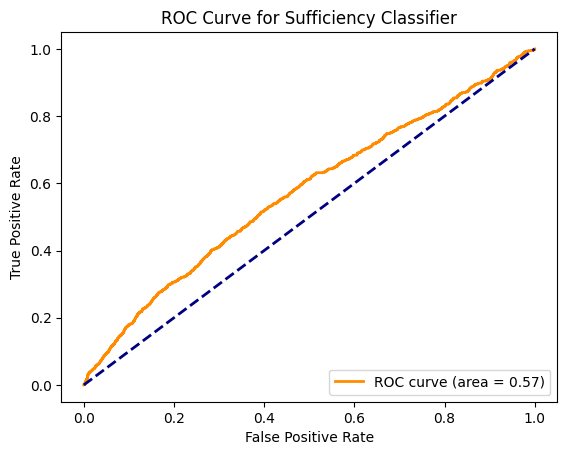

({'independence': 0.007337292446139584,
  'separation': 0.0034023671183925595,
  'sufficiency': 0.0008904533615831628},
 {'independence': 0.0004889254987827947,
  'separation': 0.00040563908906293927,
  'sufficiency': 0.0002770347621973752})

In [15]:
ols_model = sm.OLS(target, sm.add_constant(features_numeric))
result = ols_model.fit()
# print(result.summary())

y_pred = result.predict(sm.add_constant(features_numeric))

evaluate_fairness(y_pred, target, df["minority"])

({'independence': 0.0073372924461363965, 'separation': 0.003402367118390028, 'sufficiency': 0.000890453361583835}, {'independence': 0.0004889254987827011, 'separation': 0.0004056390890628093, 'sufficiency': 0.0002770347621974925})


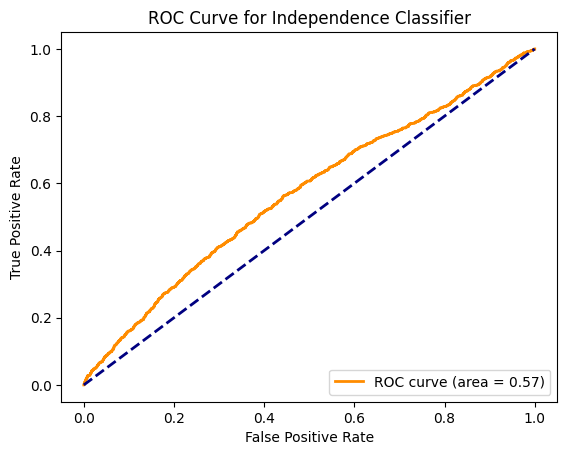

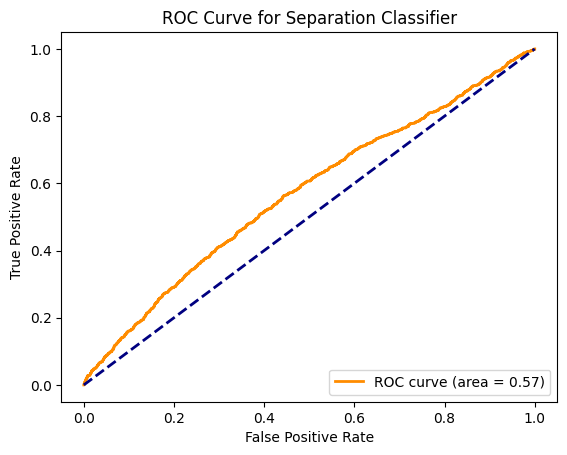

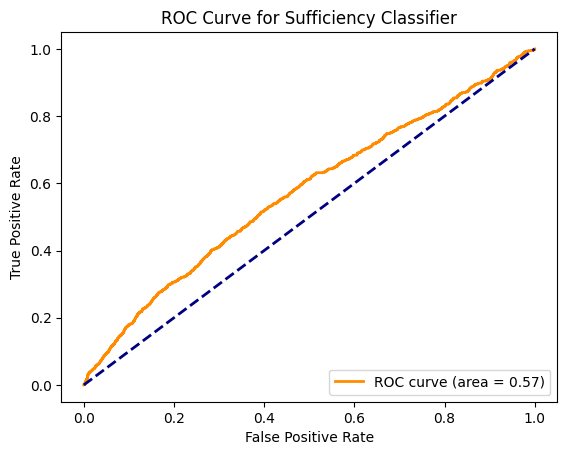

({'independence': 0.0073372924461363965,
  'separation': 0.003402367118390028,
  'sufficiency': 0.000890453361583835},
 {'independence': 0.0004889254987827011,
  'separation': 0.0004056390890628093,
  'sufficiency': 0.0002770347621974925})

In [16]:
lr_full = LinearRegression()
lr_full.fit(features_numeric, target)

y_pred_lr = lr_full.predict(features_numeric)


evaluate_fairness(y_pred_lr, target, df["minority"])

({'independence': 0.008829842574812004, 'separation': 0.004318981033798546, 'sufficiency': 0.0003062901625056496}, {'independence': 0.00045073456330969923, 'separation': 0.00037985327215897573, 'sufficiency': 0.0001537540570003378})


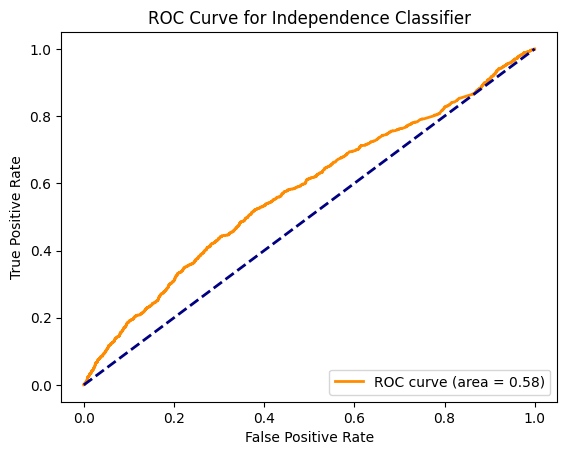

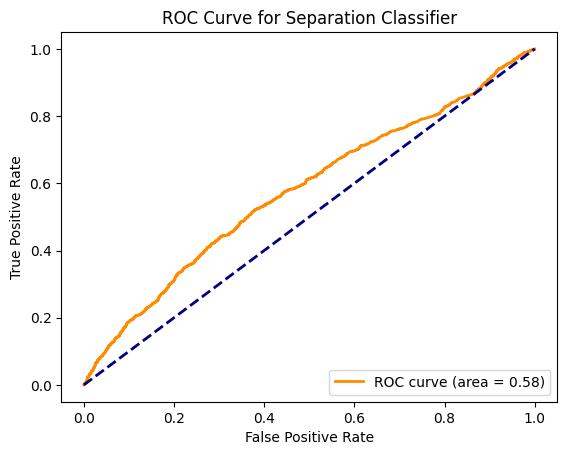

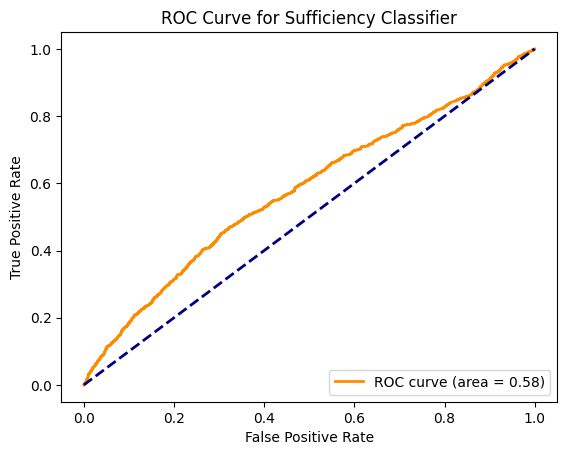

({'independence': 0.008829842574812004,
  'separation': 0.004318981033798546,
  'sufficiency': 0.0003062901625056496},
 {'independence': 0.00045073456330969923,
  'separation': 0.00037985327215897573,
  'sufficiency': 0.0001537540570003378})

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    max_depth=7,
    min_samples_leaf=10,
    n_estimators=100,
)
rf.fit(features_numeric, target)

y_pred_rf = rf.predict(features_numeric)

evaluate_fairness(y_pred_rf, target, df["minority"])

({'independence': 0.01381703022594818, 'separation': 0.009719214893472047, 'sufficiency': 0.000700208435604841}, {'independence': 0.0007158157145237923, 'separation': 0.0007222990069096337, 'sufficiency': 0.00024913775643264707})


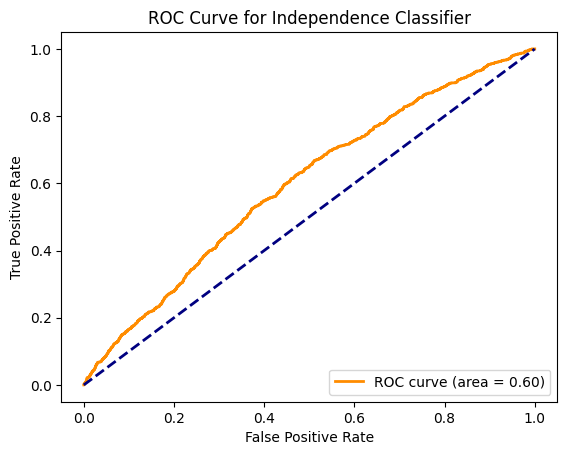

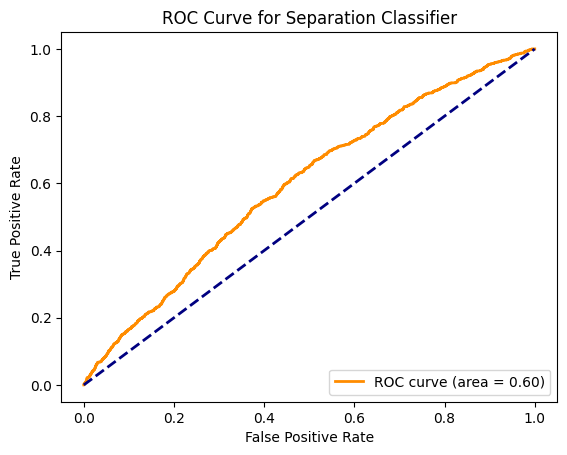

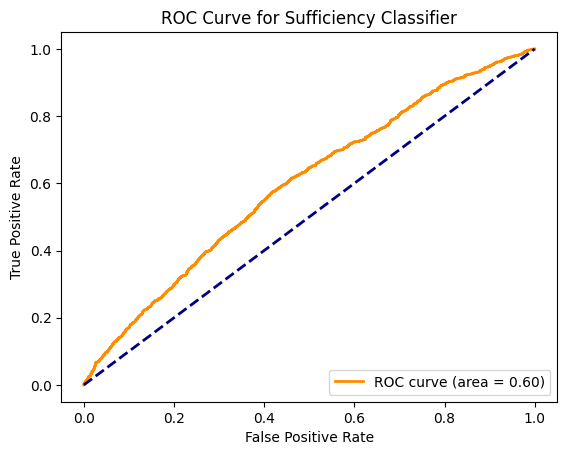

({'independence': 0.01381703022594818,
  'separation': 0.009719214893472047,
  'sufficiency': 0.000700208435604841},
 {'independence': 0.0007158157145237923,
  'separation': 0.0007222990069096337,
  'sufficiency': 0.00024913775643264707})

In [18]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(features_numeric, target)

y_pred_lasso = lasso.predict(features_numeric)

evaluate_fairness(y_pred_lasso, target, df["minority"])

({'independence': 0.007338646920491661, 'separation': 0.0034034524848093653, 'sufficiency': 0.0008901782079037653}, {'independence': 0.0004889359622229356, 'separation': 0.0004056595998202953, 'sufficiency': 0.0002769894140645514})


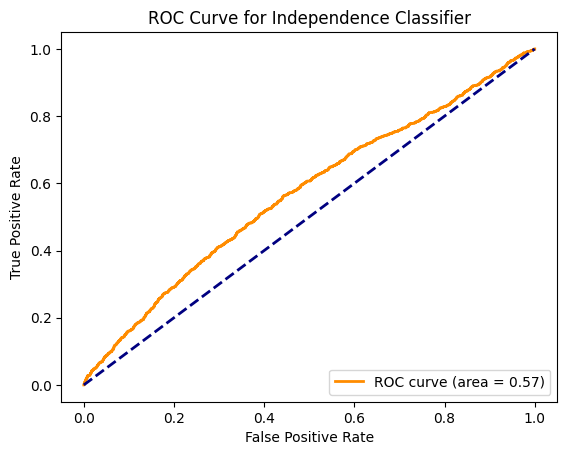

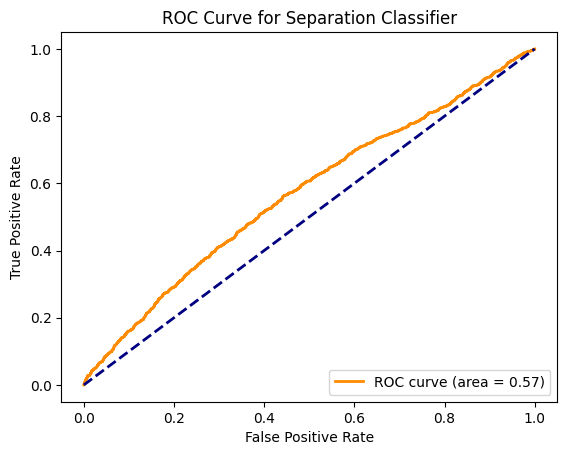

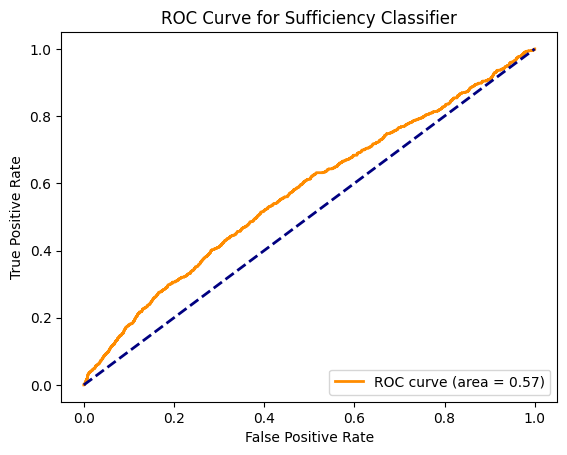

({'independence': 0.007338646920491661,
  'separation': 0.0034034524848093653,
  'sufficiency': 0.0008901782079037653},
 {'independence': 0.0004889359622229356,
  'separation': 0.0004056595998202953,
  'sufficiency': 0.0002769894140645514})

In [19]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(features_numeric, target)

y_pred_ridge = ridge.predict(features_numeric)

evaluate_fairness(y_pred_ridge, target, df["minority"])

({'independence': 0.0074733346208269965, 'separation': 0.0035335154806516397, 'sufficiency': 0.0008850089868046968}, {'independence': 0.0004786512733945244, 'separation': 0.0004011276910249444, 'sufficiency': 0.0002771770717650905})


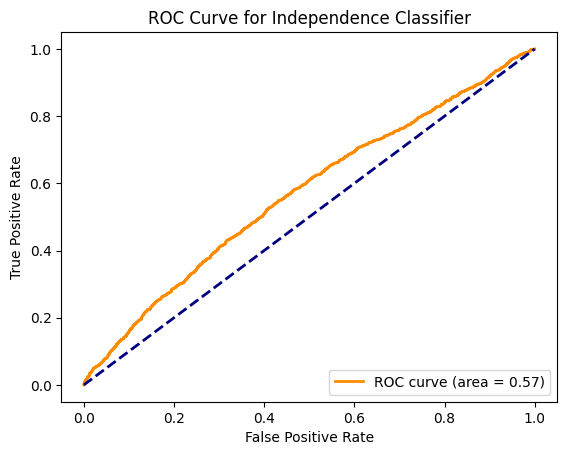

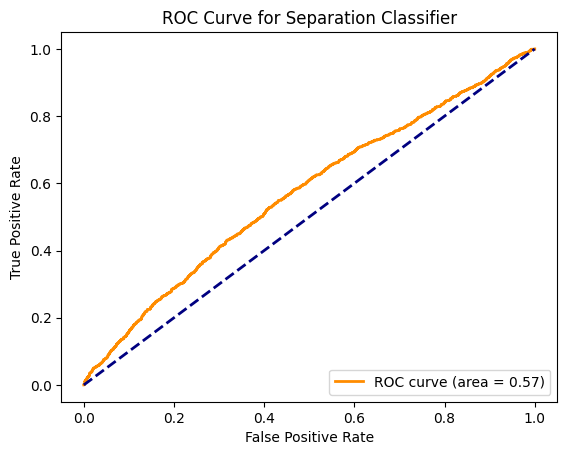

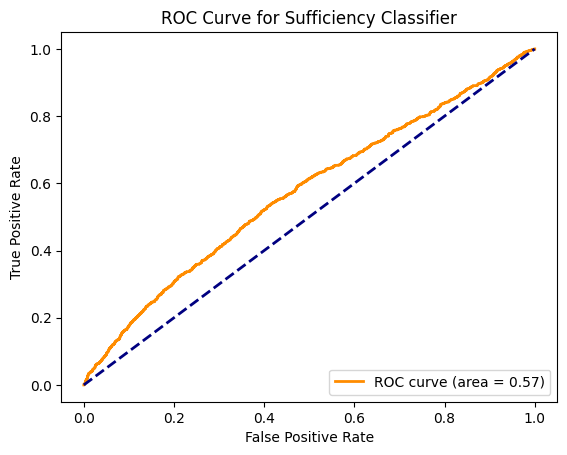

In [20]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.001)
elastic.fit(features_numeric, target)

y_pred_elastic = elastic.predict(features_numeric)

auc_elastic = evaluate_fairness(y_pred_elastic, target, df["minority"])